# Lecture 20: Class demo

UBC 2025-26

## Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
from utils import *

plt.rcParams["font.size"] = 12

import warnings

warnings.filterwarnings("default")
DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")

In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message=".*`disp` and `iprint` options of the L-BFGS-B solver are deprecated.*",
)

<br><br>

## Data

Let's work with this dataset [Customer Churn Dataset](https://www.kaggle.com/blastchar/telco-customer-churn), which is collected at a fixed time. 

In [3]:
df = pd.read_csv(DATA_DIR + "WA_Fn-UseC_-Telco-Customer-Churn.csv")
train_df, test_df = train_test_split(df, random_state=123)
train_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6464,4726-DLWQN,Male,1,No,No,50,Yes,Yes,DSL,Yes,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.6,No
5707,4537-DKTAL,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.4,No
3442,0468-YRPXN,Male,0,No,No,29,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.1,No
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
6124,7153-CHRBV,Female,0,Yes,Yes,57,Yes,No,DSL,Yes,...,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35,No


In [4]:
train_df.shape

(5282, 21)

In [5]:
train_df["Churn"].value_counts()

Churn
No     3912
Yes    1370
Name: count, dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   object 
 1

Question: Does this mean there is no missing data?

Ok, let's try our usual approach:

In [7]:
train_df["SeniorCitizen"].value_counts()

SeniorCitizen
0    4430
1     852
Name: count, dtype: int64

In [8]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
drop_features = ["customerID"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [9]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [10]:
# preprocessor.fit(train_df);

Hmmm, one of the numeric features is causing problems?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Oh, looks like `TotalCharges` is not a numeric type. What if we change the type of this column to float? 

In [12]:
# train_df["TotalCharges"] = train_df["TotalCharges"].astype(float)

Argh!!

In [13]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print(val)

Any ideas?

Well, it turns out we can't see those problematic values because they are whitespace!

In [14]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print('"%s"' % val)

" "
" "
" "
" "
" "
" "
" "
" "


Let's replace the whitespaces with NaNs. 

In [15]:
train_df = train_df.assign(
    TotalCharges=train_df["TotalCharges"].replace(" ", np.nan).astype(float)
)
test_df = test_df.assign(
    TotalCharges=test_df["TotalCharges"].replace(" ", np.nan).astype(float)
)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   object 
 1

But now we are going to have missing values and we need to include imputation for numeric features in our preprocessor. 

In [17]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
    verbose_feature_names_out=False,
)

Now let's try that again...

In [18]:
preprocessor.fit(train_df);

It worked! Let's get the column names of the transformed data from the column transformer.

In [19]:
new_columns = preprocessor.get_feature_names_out()

In [20]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)
X_test_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)

In [21]:
X_train_enc.head()

,tenure,MonthlyCharges,TotalCharges,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,Dependents_No,Dependents_Yes,SeniorCitizen
6464,0.707712,0.185175,0.513678,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
5707,-1.248999,-0.641538,-0.979562,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3442,-0.148349,1.133562,0.226789,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3932,-1.248999,0.458524,-0.950696,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
6124,0.993065,-0.183179,0.433814,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [22]:
results = {}

In [23]:
X_train = train_df.drop(columns=["Churn"])
X_test = test_df.drop(columns=["Churn"])

y_train = train_df["Churn"]
y_test = test_df["Churn"]

<br><br>

<br><br><br><br>

## Kaplan-Meier survival curve

- We'll use a package called `lifelines` for survival analysis in Python. Start by installing it in the course `conda` environment. 

```
conda install conda-forge::lifelines
```

- We'll start with a model called `KaplanMeierFitter` from `lifelines` package to get a Kaplan Meier curve.
  
- The [original paper by Kaplan and Meier](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf) has been cited over 68000 times!


- For this model we only use two columns: `tenure` and `churn`.
  
- We do not use any other features. 

In [24]:
import lifelines

But before we do anything further, I want to modify our dataset slightly:

1. I'm going to drop the `TotalCharges` (yes, after all that work fixing it) because it's a bit of a strange feature.
  - Its value actually changes over time, but we only have the value at the end.
  - We still have `MonthlyCharges`.
2. I'm not going to scale the `tenure` column, since it will be convenient to keep it in its original units of months. 

Just for our sanity, I'm redefining the features. 

Change the target because we need it in this format for `lifelines` package

In [25]:
train_df["Churn"] = train_df["Churn"].map({"Yes": 1.0, "No": 0.0})
test_df["Churn"] = test_df["Churn"].map({"Yes": 1.0, "No": 0.0})

In [42]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "TotalCharges"]
passthrough_features = ["tenure", "SeniorCitizen", "Churn"]  # don't want to scale tenure
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [43]:
preprocessing_final = make_column_transformer(
    ("passthrough", passthrough_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ("drop", drop_features),
    verbose_feature_names_out=False,
)

In [44]:
preprocessing_final.fit(train_df);

Let's get the column names of the columns created by our column transformer. 

In [45]:
new_columns = preprocessing_final.get_feature_names_out()

In [46]:
train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [47]:
train_df_surv.head()

,tenure,SeniorCitizen,Churn,MonthlyCharges,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,...,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,Dependents_No,Dependents_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,PhoneService_No,PhoneService_Yes
6464,50.0,1.0,0.0,0.185175,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5707,2.0,0.0,0.0,-0.641538,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3442,29.0,0.0,0.0,1.133562,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3932,2.0,1.0,1.0,0.458524,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6124,57.0,0.0,0.0,-0.183179,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


- Let's visualize the Kaplan-Meier survival curve.
- This is a non-sklearn tool but the syntax is similar to `sklearn`

In [48]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(train_df_surv["tenure"], train_df_surv["Churn"]);

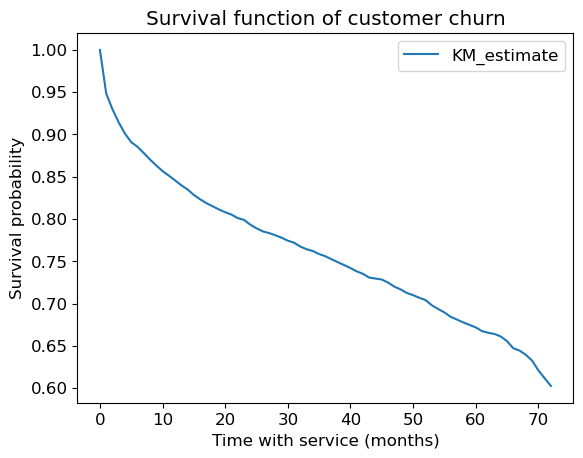

In [49]:
kmf.survival_function_.plot()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- What is this plot telling us?
  
- It shows the probability of survival over time.
- For example, after 20 months the probability of survival is ~0.8. 
- Over time it's going down. 

What's the average tenure?

In [50]:
np.mean(train_df_surv["tenure"])

np.float64(32.6391518364256)

What's the average tenure of the people who churned?

In [51]:
np.mean(train_df_surv.query("Churn == 1.0")["tenure"])

np.float64(17.854744525547446)

What's the average tenure of the people who did not churn? 

In [52]:
np.mean(train_df_surv.query("Churn == 0.0")["tenure"])

np.float64(37.816717791411044)

- Let's look at the histogram of number of people who have not churned. 
- The key point here is that people _joined at different times_. 

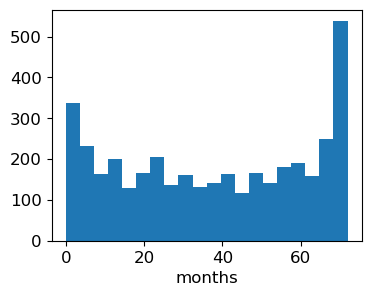

In [53]:
plt.figure(figsize=(4, 3))
train_df_surv[train_df_surv["Churn"] == 0]["tenure"].hist(bins=20, grid=False)
plt.xlabel("months");

- Since the data was collected at a fixed time and these are the people who hadn't yet churned, those with larger `tenure` values here must have joined earlier.

Lifelines can also give us some "error bars":

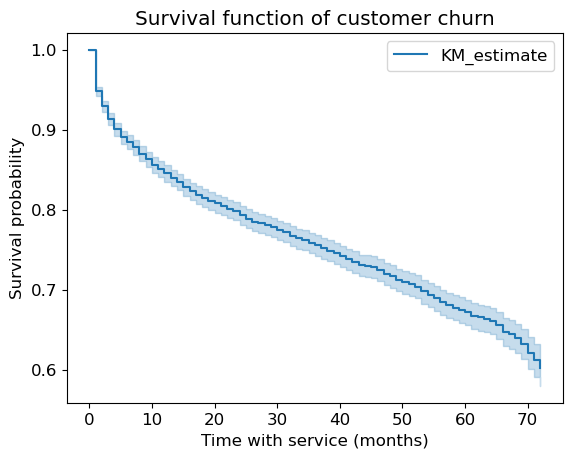

In [54]:
kmf.plot_survival_function()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- We already have some actionable information here.
  
- The curve drops down fast at the beginning suggesting that people tend to leave early on. 
- If there would have been a big drop in the curve, it means a bunch of people left at that time (e.g., after a 1-month free trial). 

We can also create the K-M curve for different subgroups:

In [55]:
T = train_df_surv["tenure"]
E = train_df_surv["Churn"]
senior = train_df_surv["SeniorCitizen"] == 1

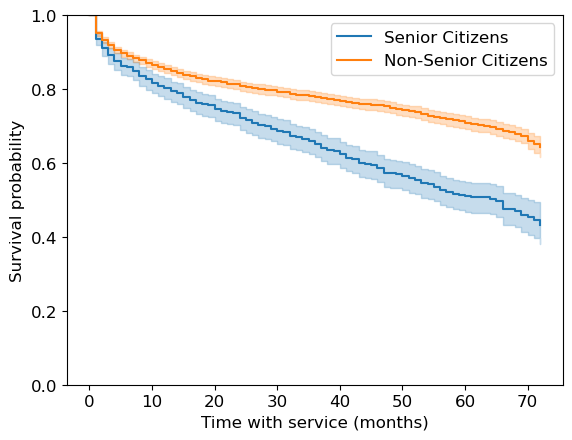

In [56]:
ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot_survival_function(ax=ax)

plt.ylim(0, 1)
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- It looks like senior citizens churn more quickly than others.
  
- This is quite useful!

<br><br>

## Cox proportional hazards model

- We haven't been incorporating other features in the model so far.
  
- The Cox proportional hazards model is a commonly used model that allows us to interpret how features influence a censored tenure/duration. 
- You can think of it like linear regression for survival analysis: we will get a coefficient for each feature that tells us how it influences survival.
- It makes some strong assumptions (the proportional hazards assumption) that may not be true, but we won't go into this here.
- The proportional hazard model works multiplicatively, like linear regression with log-transformed targets.

In [59]:
cph = lifelines.CoxPHFitter()
# cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

- Ok, going to [this URL](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model), it seems the easiest solution is to add a penalizer.
  
  - FYI this is related to switching from `LinearRegression` to `Ridge`.
    
  - Adding `drop='first'` on our OHE might have helped with this.
  - (For 340 folks: we're adding regularization; `lifelines` adds both L1 and L2 regularization, aka elastic net)

In [60]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

/Users/kvarada/miniforge3/envs/cpsc330/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1217: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"


We can look at the coefficients learned by the model and start interpreting them! 

In [61]:
cph_params = pd.DataFrame(cph.params_).sort_values(by="coef", ascending=False)
cph_params

,coef
covariate,
Contract_Month-to-month,0.812875
OnlineSecurity_No,0.311151
OnlineBackup_No,0.298561
PaymentMethod_Electronic check,0.280801
Partner_No,0.244814
TechSupport_No,0.212303
InternetService_Fiber optic,0.186869
DeviceProtection_No,0.180214
PaymentMethod_Mailed check,0.172697


How to interpret these coefficients In the Cox Proportional Hazards model? 
- A positive coefficient indicates that higher values of the feature are associated with higher hazard rates, meaning they are associated with worse survival.
  
- A negative coefficient indicates that higher values of the feature are associated with lower hazard rates, meaning they are associated with better survival.

- In our example, it looks like `Contract_Month-to-month` has a positive coefficient

    - If the contract is month-to-month, it leads to more churn worse survival (😔)
      
- In our example, it looks like `Contract_Two year` has a negative coefficient

    - If the contract is two-year contract, it leads to less churn better survival (😊)
    
This makes sense!!!

Could we have gotten this type of information out of sklearn?
- Yes, let's try it out! 
- But remember that using survival analysis approach is more appropriate for such problems. 

In [62]:
y_train.head()

6464     No
5707     No
3442     No
3932    Yes
6124     No
Name: Churn, dtype: object

In [63]:
X_train.drop(columns=["tenure"]).head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6464,4726-DLWQN,Male,1,No,No,Yes,Yes,DSL,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.60
5707,4537-DKTAL,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.40
3442,0468-YRPXN,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.10
3932,1304-NECVQ,Female,1,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55
6124,7153-CHRBV,Female,0,Yes,Yes,Yes,No,DSL,Yes,No,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35


I'm redefining feature types and our preprocessor for our sanity. 

In [64]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "tenure", "TotalCharges"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [65]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
    verbose_feature_names_out=False
)

In [66]:
preprocessor.fit(X_train);

In [67]:
new_columns = preprocessor.get_feature_names_out()

In [68]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
lr.fit(X_train, y_train)
lr_coefs = pd.DataFrame(
    data=np.squeeze(lr[1].coef_), index=new_columns, columns=["Coefficient"]
)

In [69]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
Contract_Month-to-month,1.011332
OnlineSecurity_No,0.241489
PaymentMethod_Electronic check,0.232751
InternetService_Fiber optic,0.223460
MonthlyCharges,0.216123
OnlineBackup_No,0.147401
SeniorCitizen,0.126011
TechSupport_No,0.121403
PaymentMethod_Mailed check,0.010721
DeviceProtection_No,0.001249


- There is some agreement, which is good.
  
- But our survival model is much more useful.
  - Not to mention more correct.

- One thing we get with `lifelines` is confidence intervals on the coefficients:

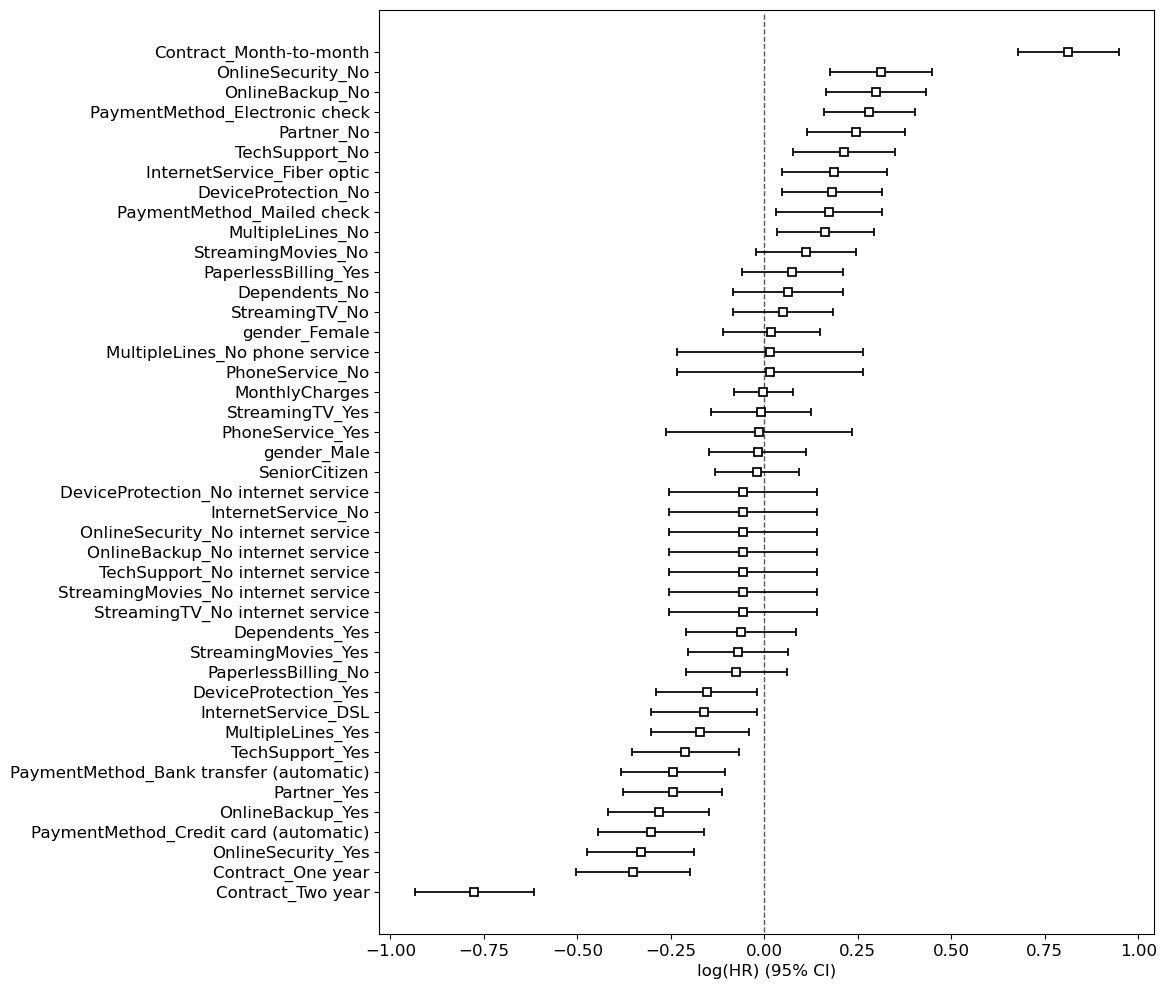

In [70]:
plt.figure(figsize=(10, 12))
cph.plot();

- (We could probably get the same for logistic regression if using `statsmodels` instead of sklearn.)
- However, in general, I would be careful with all of this.
  
- Ideally we would have more statistical training when using `lifelines` - there is a lot that can go wrong.
  - It comes with various diagnostics as well.
- But I think it's very useful to know about survival analysis and the availability of software to deal with it.
- Oh, and there are lots of other nice plots.

### Survival plots

- Let's look at the survival plots for the people with 
    - two-year contract (Contract_Two year = 1) and
      
    - people without two-year contract (Contract_Two year = 0)
- As expected, the former survive longer. 

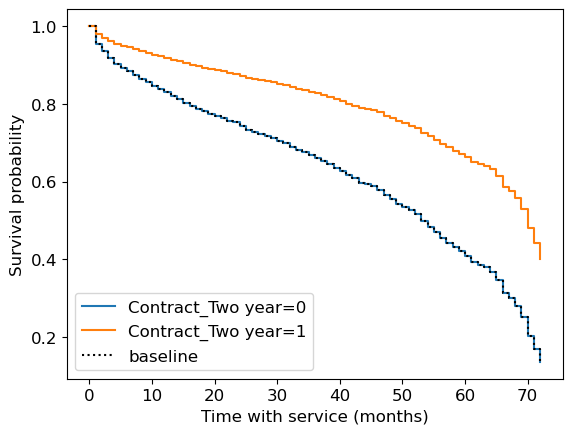

In [71]:
cph.plot_partial_effects_on_outcome("Contract_Two year", [0, 1])
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

Now let's look at the survival plots for the people with different MonthlyCharges. 

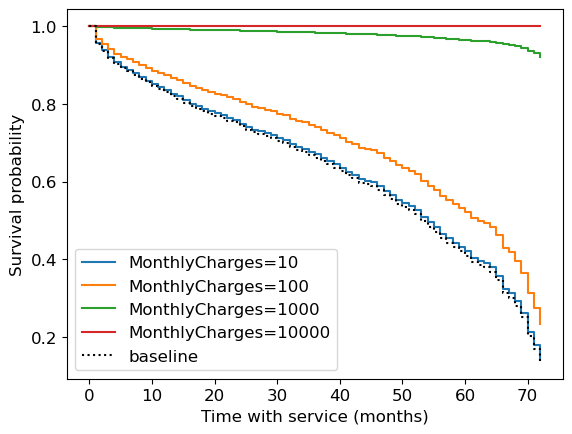

In [72]:
cph.plot_partial_effects_on_outcome("MonthlyCharges", [10, 100, 1000, 10_000])
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- That's the thing with linear models, they can't stop the growth.
  
- We have a negative coefficient associated with `MonthlyCharges`

In [73]:
cph_params.loc["MonthlyCharges"]

coef   -0.003185
Name: MonthlyCharges, dtype: float64

If your monthly charges are huge, it takes this to the extreme and thinks you'll basically never churn.

<br><br><br><br>

## Prediction

- We can use survival analysis to make predictions as well.
  
- Here is the expected number of months to churn for the first 5 customers in the test set:

In [74]:
test_X = test_df_surv.drop(columns=["tenure", "Churn"])

How long each non-churned customer is likely to stay according to the model assuming that they just joined right now?  

In [75]:
cph.predict_expectation(test_X).head()  # assumes they just joined right now

941     35.206724
1404    69.023086
5515    68.608565
3684    27.565062
7017    67.890933
dtype: float64

Survival curves for first 5 customers in the test set:

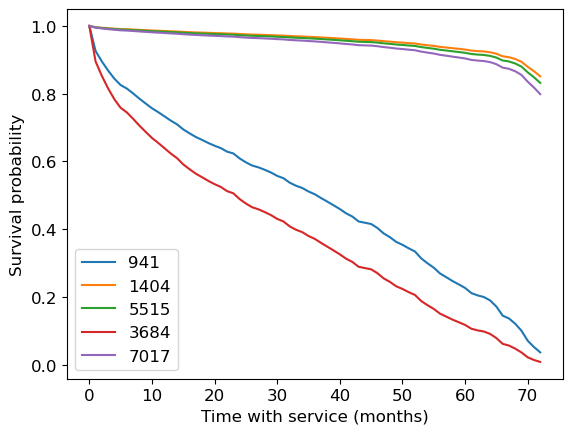

In [76]:
cph.predict_survival_function(test_X[:5]).plot()
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

From `predict_survival_function` documentation:

> Predict the survival function for individuals, given their covariates. This assumes that the individual just entered the study (that is, we do not condition on how long they have already lived for.) 

So these curves are "starting now".

<br><br>

### (Optional) Given customer has been here $n$ months, what's the outlook?

- There's no probability prerequisite for this course, so this is optional material.
  
- But you can do some interesting stuff here with conditional probabilities.
- "Given that a customer has been here 5 months, what's the outlook?"
  - It will be different than for a new customer.
    
  - Thus, we might still want to predict for the non-churned customers in the training set!
  - Not something we really thought about with our traditional supervised learning.

Let's get the customers who have not churned yet.  

In [ ]:
train_df_surv_not_churned = train_df_surv[train_df_surv["Churn"] == 0]

We can _condition_ on the person having been around for 20 months.

In [ ]:
cph.predict_survival_function(train_df_surv_not_churned[:1], conditional_after=20)

In [ ]:
plt.figure()
cph.predict_survival_function(train_df_surv_not_churned[:1]).plot(ax=plt.gca())
preds = cph.predict_survival_function(
    train_df_surv_not_churned[:1], conditional_after=20
)
plt.plot(preds.index[20:], preds.values[:-20])
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability")
plt.legend(["Starting now", "Given 20 more months of service"])
plt.ylim([0, 1])
plt.xlim([1, 50]);

- Look at how the survival function (and expected lifetime) is much longer _given_ that the customer has already lasted 20 months.

- How long each non-churned customer is likely to stay according to the model assuming that they have been here for the tenure time? 
- So, we can set this to their actual tenure so far to get a prediciton of what will happen going forward:

In [ ]:
cph.predict_survival_function(
    train_df_surv_not_churned[:1],
    conditional_after=train_df_surv_not_churned[:1]["tenure"],
).plot()
plt.xlabel("Time into the future (months)")
plt.ylabel("Survival probability")
plt.ylim([0, 1])
plt.xlim([0, 20]);

- Another useful application: you could ask what is the [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value).
  - Basically, how much money do you expect to make off this customer between now and when they churn?
- With regular supervised learning, tenure was a feature and we could only predict whether or not they had churned by then.

<br><br>

## (Optional) Evaluation 

By default score returns "partial log likelihood":

In [ ]:
cph.score(train_df_surv)

In [ ]:
cph.score(test_df_surv)

We can look at the "concordance index" which is more interpretable:

In [ ]:
cph.concordance_index_

In [ ]:
cph.score(train_df_surv, scoring_method="concordance_index")

In [ ]:
cph.score(test_df_surv, scoring_method="concordance_index")

From the documentation [here](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-and-calibration-in-survival-regression):

> Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:
> 
> - 0.5 is the expected result from random predictions,
> - 1.0 is perfect concordance and,
> - 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
> 
> [Here](https://stats.stackexchange.com/a/478305/11867) is an excellent introduction & description of the c-index for new users.


In [ ]:
cph.log_likelihood_ratio_test()

In [ ]:
cph.check_assumptions(train_df_surv)

<br><br><br><br>

## Other approaches / what did we not cover? 

There are many other approaches to modelling in survival analysis:

- Time-varying proportional hazards.
  - What if some of the features change over time, e.g. plan type, number of lines, etc.
- Approaches based on deep learning, e.g. the [pysurvival](https://square.github.io/pysurvival/) package.
- Random survival forests.
- And more...

### Types of censoring
There are also various types and sub-types of censoring we didn't cover:

- What we did today is called "right censoring"
- Sub-types within right censoring
  - Did everyone join at the same time?
  - Other reasons the data might be censored at random times, e.g. the person died?
- Left censoring
- Interval censoring

## Summary

- Censoring and incorrect approaches to handling it
  - Throw away people who haven't churned
  - Assume everyone churns today
- Predicting tenure vs. churned
- Survival analysis encompasses both of these, and deals with censoring
- And it can make rich and interesting predictions!
- KM model -> doesn't look at features
- CPH model -> like linear regression, does look at the features

## References

Some people working with this same dataset:

- https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
- https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 (Cox)
- https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

lifelines documentation: 
- https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
- https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis